In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def find_repo_root(marker="README.md"):
    """Walk up from current path to find the repo root containing `marker`."""
    current = Path().resolve()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent
    raise FileNotFoundError(f"Could not find repo root with marker '{marker}'")

# Find repo root using a known file at the root
repo_root = find_repo_root("README.md")

# Path to the CSV file
GFOC_path = repo_root / Path('Dataset/Dataset_MSc/GFOC_RDCDFI.csv')

# Load only specific columns that you need for analysis
# This will significantly reduce memory usage
columns_needed = ['time', 'orbital_decay', 'se_orbital_decay']

# Try to load with limited columns first
try:
    GFOC_data = pd.read_csv(GFOC_path, usecols=columns_needed, low_memory=True)
    print(f"Successfully loaded data with shape: {GFOC_data.shape}")
except MemoryError:
    print("Still running out of memory. Loading in chunks...")
    # If still out of memory, load in chunks
    chunk_list = []
    chunksize = 50000  # Adjust this number based on your available memory
    
    for chunk in pd.read_csv(GFOC_path, usecols=columns_needed, chunksize=chunksize, low_memory=True):
        chunk_list.append(chunk)
    
    GFOC_data = pd.concat(chunk_list, ignore_index=True)
    print(f"Successfully loaded data in chunks with shape: {GFOC_data.shape}")

Successfully loaded data with shape: (1486079, 3)


Lets have a look at the raw data:

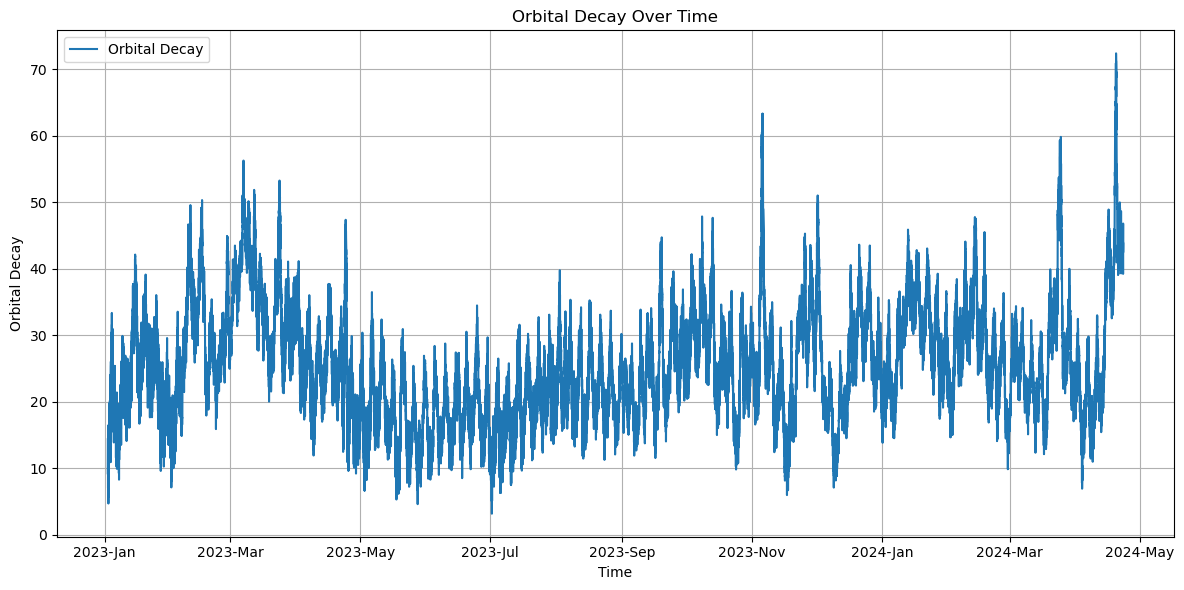

In [4]:
import matplotlib.dates as mdates
import numpy as np

# =========================== Input ===================================
# start_date = '2024-05-01 00:00:00'
# end_date = '2024-05-15 00:00:00'
start_date = GFOC_data['time'].values[0]
# end_date = GFOC_data['time'].values[-4322] #removed gap by ignoring the last 4321 values
end_date = GFOC_data['time'].values[-54322] #removed gap + big event on May 11th by ignoring the last 4321 values

# Add an option for monthly, daily, or hourly ticks
tick_interval = 'monthly'  # Change to 'monthly', 'daily', or 'hourly'
tick_step = 2  # Step for the ticks (e.g., every month =1, every 2 months = 2, etc)

# plt.style.use('dark_background')
plt.style.use('default')

# Helper function for tick formatting
def format_ticks(ax, tick_interval, tick_step):
    if tick_interval == 'monthly':
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))                         
    elif tick_interval == 'daily':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    elif tick_interval == 'hourly':
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=tick_step))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.tick_params(axis='x', rotation=0)
# =====================================================================


GFOC_data = GFOC_data[(GFOC_data['time'] >= start_date) & (GFOC_data['time'] <= end_date)]
# Time conversion
GFOC_time = GFOC_data['time']
GFOC_time = pd.to_datetime(GFOC_time, format='%Y-%m-%d %H:%M:%S')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(GFOC_time, GFOC_data['orbital_decay'], label='Orbital Decay')
format_ticks(ax, tick_interval, tick_step)
ax.set_xlabel('Time')
ax.set_ylabel('Orbital Decay')
ax.set_title('Orbital Decay Over Time')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

There are very clear periodic changes at
- submonthly levels (~4 day period)
- monthly levels (especially at the beginning and end of the dataset)
as well as some extreme events/outliers. We want to remove the periodic and nonperiodic trends in order to analyse the bigger events.

## 1. Detrend the long-term baseline

For this we have multiple options
- Savitzki-Golay filter
- Lowess smoother

In [5]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter to smooth the data3
window_length = 120001  # Must be odd and less than the length of the data
polyorder = 3  # Polynomial order for the filter
#append smoothed data to the DataFrame
GFOC_data['orbital_decay_savgol'] = savgol_filter(GFOC_data['orbital_decay'].values, window_length, polyorder)

In [6]:
# import statsmodels.api as sm

# lowess = sm.nonparametric.lowess
# fraction = window_length / len(GFOC_data['orbital_decay'])  # Fraction of data used for smoothing

# x = GFOC_time.astype(np.int64) // 10**9  # Convert to seconds for LOWESS
# y = GFOC_data['orbital_decay'].values
# z = lowess(y, x, frac=fraction)

# GFOC_data['orbital_decay_lowess'] = z[:, 1]

Save data to a csv to reduce loading time.

In [7]:
# GFOC_data['orbital_decay_savgol'].to_csv('orbital_decay_savgol_120001.csv', index=False)
# GFOC_data['orbital_decay_lowess'].to_csv('orbital_decay_lowess_1.csv', index=False)

Load csv

In [8]:
# GFOC_data['orbital_decay_savgol'] = pd.read_csv('orbital_decay_savgol_10001.csv')
# GFOC_data['orbital_decay_lowess'] = pd.read_csv('orbital_decay_lowess_10001.csv')

#### Notes
Different window lengths
- at 51 there is no visible change
- at 501 the curve is smoother but still follows the extreme
- at 5001 the curve is again smoother but still too close to the real data
- at 50001 the curve is at the point where it looks very similar to the lowess smoother, however the solar period is filtered out
- at 120001 the curve still has the main solar period but looks smooth enough

#### Plot detrended curve

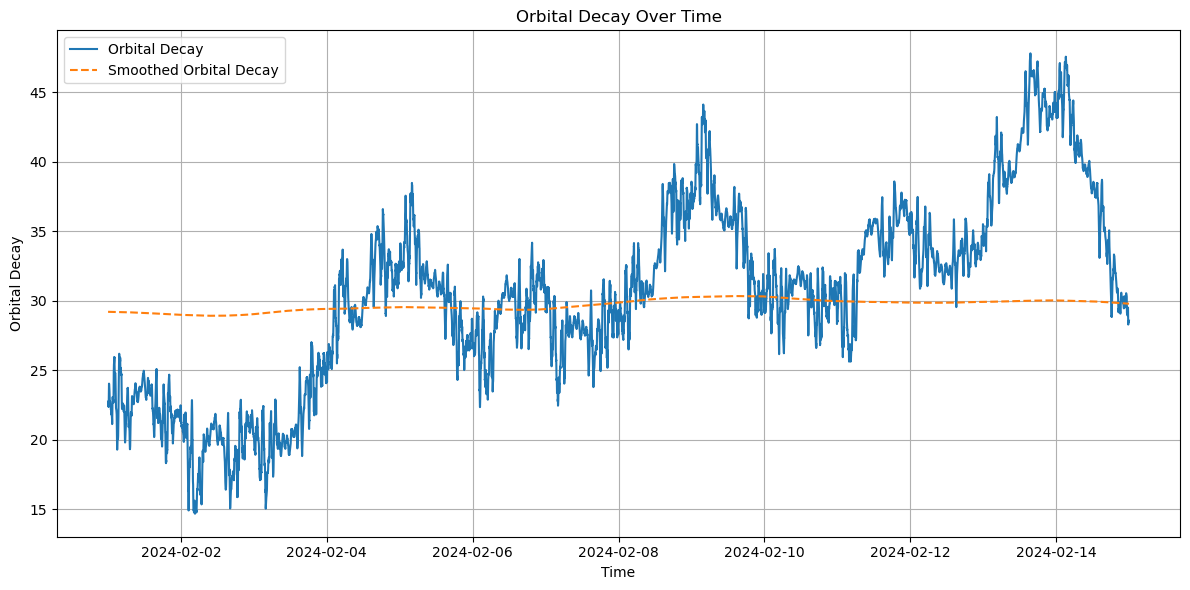

In [9]:
# =========================== Input ===================================
start_date = '2024-02-01 00:00:00'
end_date = '2024-02-15 00:00:00'
# start_date = GFOC_data['time'].values[0]
# end_date = GFOC_data['time'].values[-1]

# Add an option for monthly, daily, or hourly ticks
tick_interval = 'daily'  # Change to 'monthly', 'daily', or 'hourly'
tick_step = 2  # Step for the ticks (e.g., every month =1, every 2 months = 2, etc)

# plt.style.use('dark_background')
plt.style.use('default')

# =====================================================================


GFOC_subset = GFOC_data[(GFOC_data['time'] >= start_date) & (GFOC_data['time'] <= end_date)]
# Time conversion
GFOC_time = GFOC_subset['time']
GFOC_time = pd.to_datetime(GFOC_time, format='%Y-%m-%d %H:%M:%S')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(GFOC_time, GFOC_subset['orbital_decay'], label='Orbital Decay')
ax.plot(GFOC_time, GFOC_subset['orbital_decay_savgol'], label='Smoothed Orbital Decay', linestyle='--')
# ax.plot(GFOC_time, GFOC_subset['orbital_decay_lowess'], label='LOWESS Smoothed Orbital Decay', linestyle=':')
format_ticks(ax, tick_interval, tick_step)
ax.set_xlabel('Time')
ax.set_ylabel('Orbital Decay')
ax.set_title('Orbital Decay Over Time')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Detrend

In [10]:
GFOC_data['orbital_decay_detrended'] = GFOC_data['orbital_decay'] - GFOC_data['orbital_decay_savgol']

# GFOC_data['orbital_decay_detrended'] = GFOC_data['orbital_decay_savgol']

# lowess
# GFOC_data['orbital_decay_detrended'] = GFOC_data['orbital_decay'] - GFOC_data['orbital_decay_lowess']

# GFOC_data['orbital_decay_detrended'] = GFOC_data['orbital_decay_lowess']

## 2. Normalise to zero mean & unit variance

is not necessairy for Lomb-Scargle, but ruins scales --> don't do it!

In [11]:
# GFOC_data['orbital_decay_norm'] = (GFOC_data['orbital_decay_detrended'] - GFOC_data['orbital_decay_detrended'].mean()) / GFOC_data['orbital_decay_detrended'].std()

## -1. Run Lomb-Scargle on the cleaned data

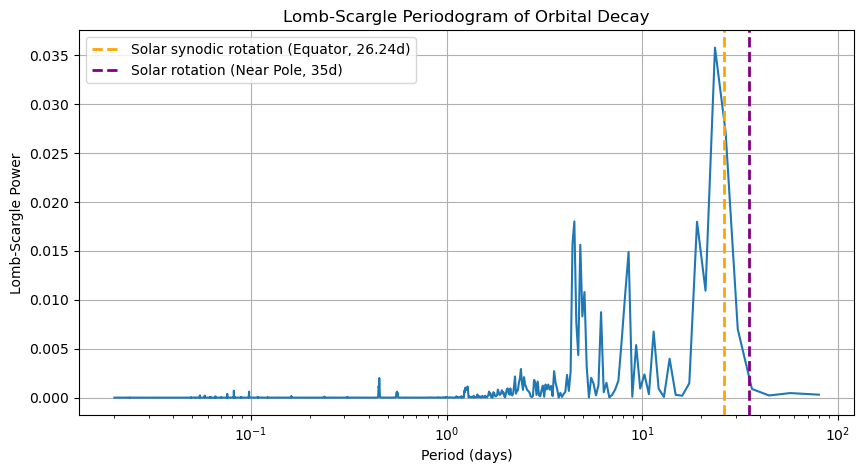

Strongest period: 23.53 days
Strongest period: 2033156.47 seconds


In [12]:
from astropy.timeseries import LombScargle


# Convert time to numerical values (in days)
times = pd.to_datetime(GFOC_data['time'], format='%Y-%m-%d %H:%M:%S')
times_num = (times - times.iloc[0]).dt.total_seconds() / (24 * 3600)  # days since start

y = GFOC_data['orbital_decay_detrended'].values

# Define frequency grid (cycles per day)
min_period = 0.02   # days
max_period = 80  # days
frequency = np.linspace(1/max_period, 1/min_period, 10000)

# Compute Lomb-Scargle periodogram
ls = LombScargle(times_num, y)
power = ls.power(frequency)

# Find the period with the highest power
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency

# Plot the periodogram
plt.figure(figsize=(10, 5))
plt.plot(1/frequency, power)
plt.xlabel('Period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.title('Lomb-Scargle Periodogram of Orbital Decay')
plt.xscale('log')
plt.grid(True)

# Add vertical lines for solar rotation periods
plt.axvline(26.24, color='orange', linestyle='--', linewidth=2, label='Solar synodic rotation (Equator, 26.24d)')
plt.axvline(35, color='purple', linestyle='--', linewidth=2, label='Solar rotation (Near Pole, 35d)')

plt.legend()
plt.show()

print(f"Strongest period: {best_period:.2f} days")
print(f"Strongest period: {best_period*24*60*60:.2f} seconds")

Using different window lengths for the Sawitzky-Golay filter results in different strongest periods
- wl=501: Strongest period: 1.96 hours
- wl=5001: Strongest period: 10.85 hours ~ 0.45 days
- wl=50001: Strongest period: 4.40 days
- wl=500001: Strongest period: 23.53 days (15min load time for SG...)

but only if the frequency grid stays the same. Otherwise those periods change as well...

---

GRACE-FO was injected into a 490-km altitude, near circular polar orbit. In this orbit, the satellite moves around the Earth from pole to pole, taking about 99 minutes to complete an orbit. During half of the orbit, the satellites view the daytime side of Earth. At the pole, the satellites cross to the nighttime side of Earth. (https://grace.jpl.nasa.gov/mission/grace-fo/)

At the equator the Solar rotation period is 24.47 days which is the sidereal motion and a synodic rotation period of 26.24 days, which is the time for a fixed feature of the Sun to rotate to the same apparent position as viewed from Earth. The rate of rotation is observed to be fastest at the equator and decreases as latitude increases. (https://www.star.bris.ac.uk/bjm/solar/solarrot.html)

## Filter by strongest period

In [13]:
y_fit = ls.model(times_num, best_frequency)

y_Lombsc = y - y_fit

GFOC_data['orbital_decay_Lombscargle'] = y_Lombsc

compare detrended model to original data

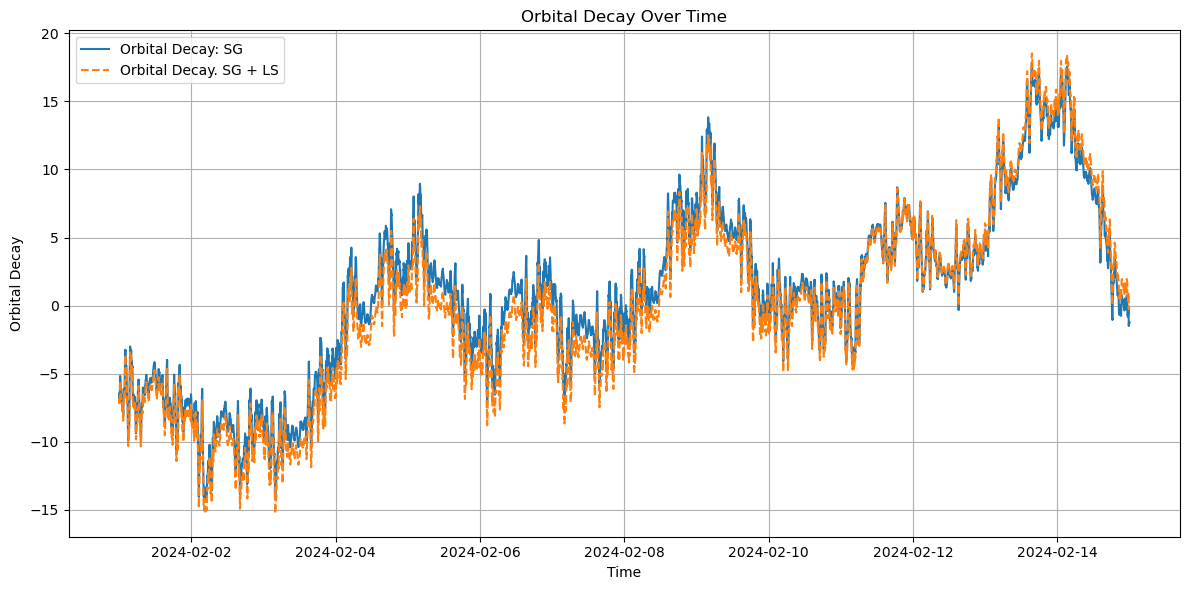

In [14]:
GFOC_subset = GFOC_data[(GFOC_data['time'] >= start_date) & (GFOC_data['time'] <= end_date)]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(GFOC_time, GFOC_subset['orbital_decay_detrended'], label='Orbital Decay: SG')
ax.plot(GFOC_time, GFOC_subset['orbital_decay_Lombscargle'], label='Orbital Decay. SG + LS', linestyle='--')
format_ticks(ax, tick_interval, tick_step)
ax.set_xlabel('Time')
ax.set_ylabel('Orbital Decay')
ax.set_title('Orbital Decay Over Time')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Question
What happens if we do multiple iterations?

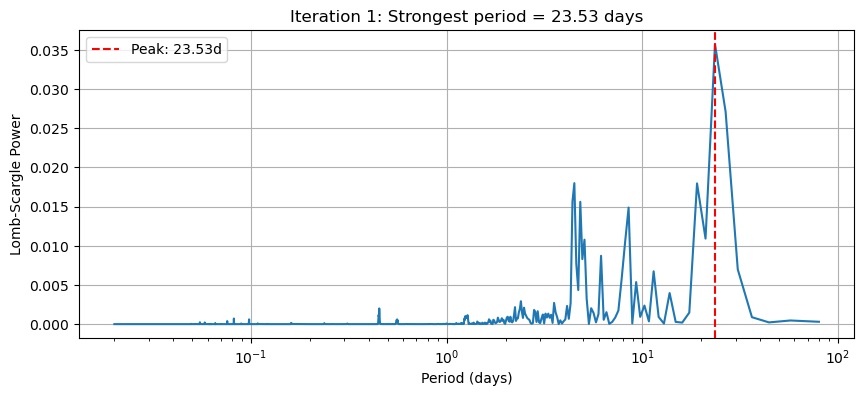

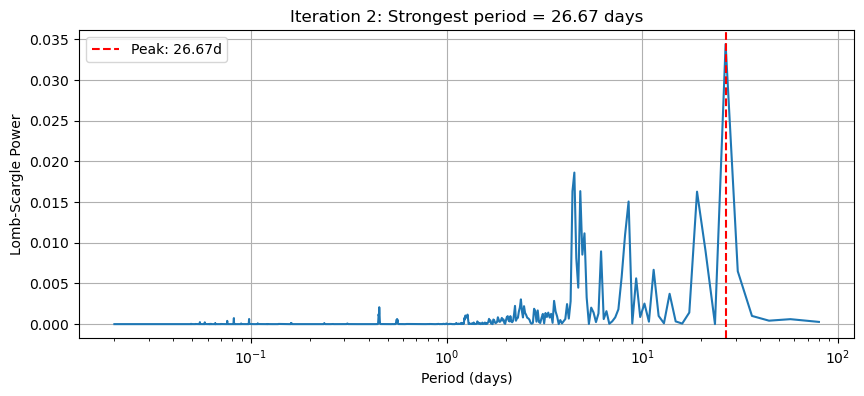

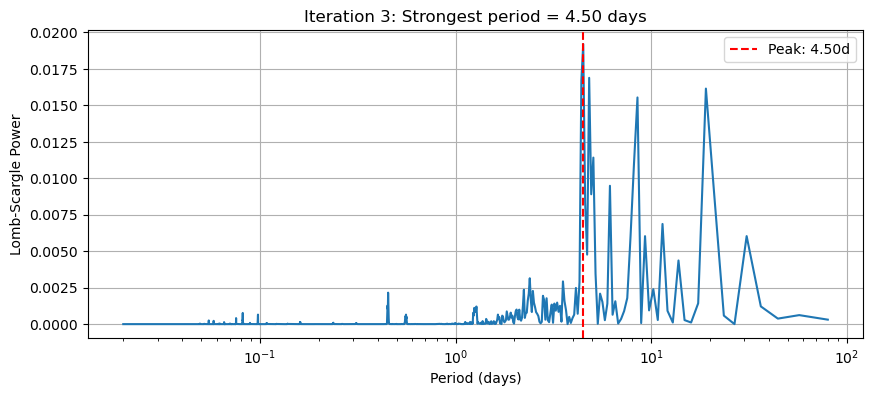

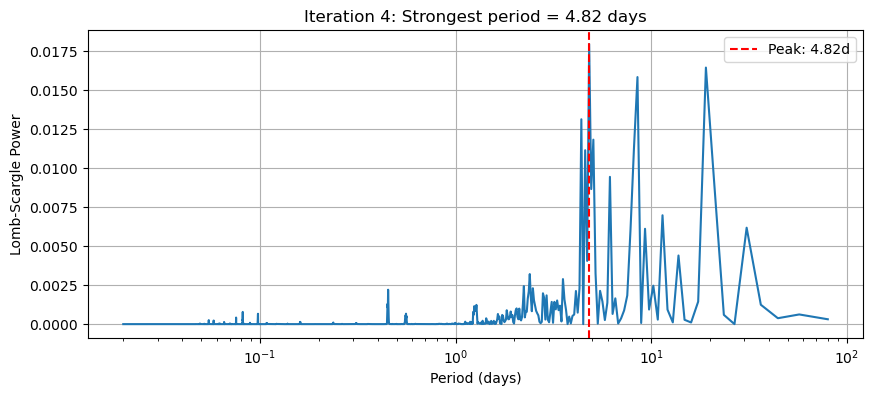

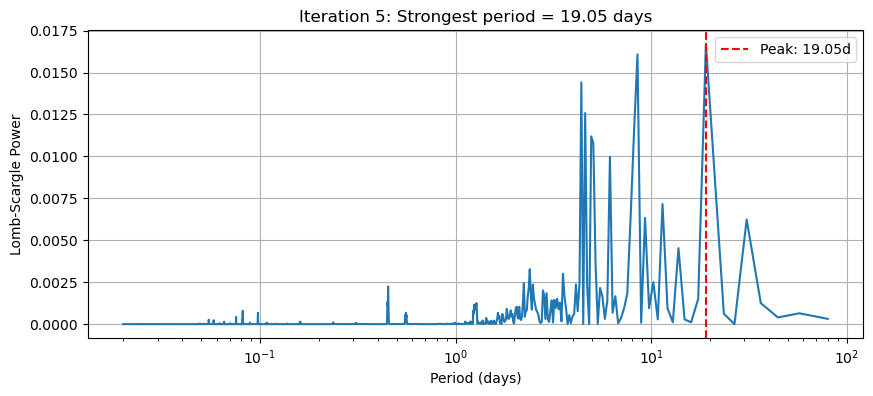

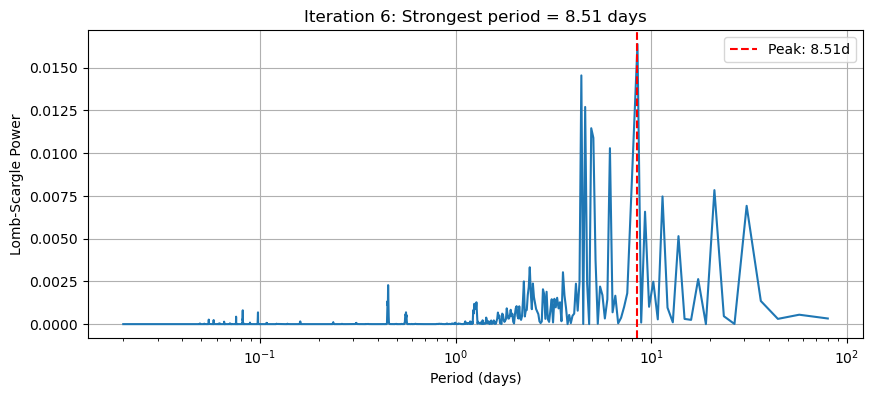

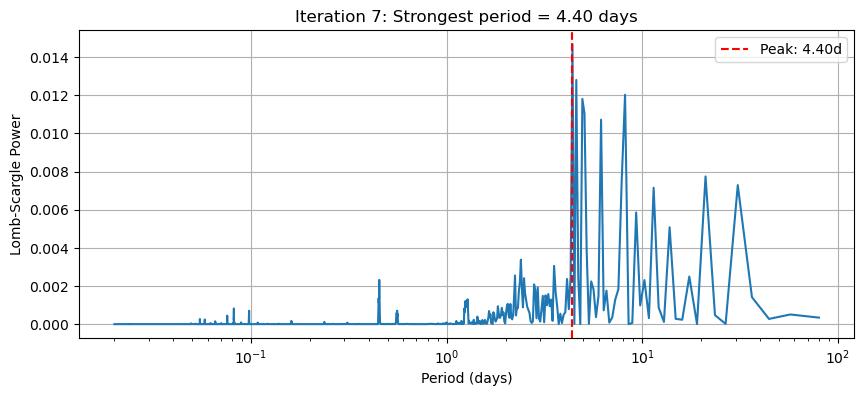

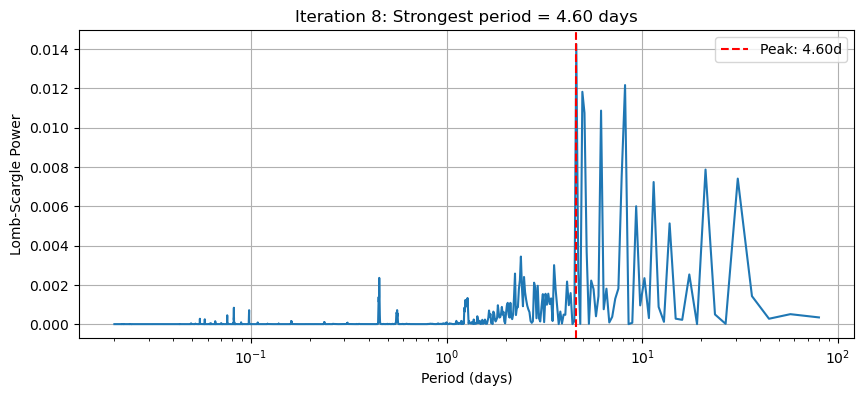

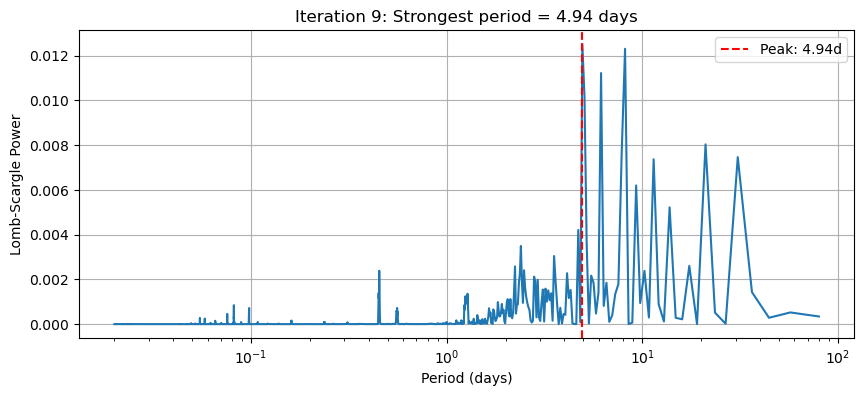

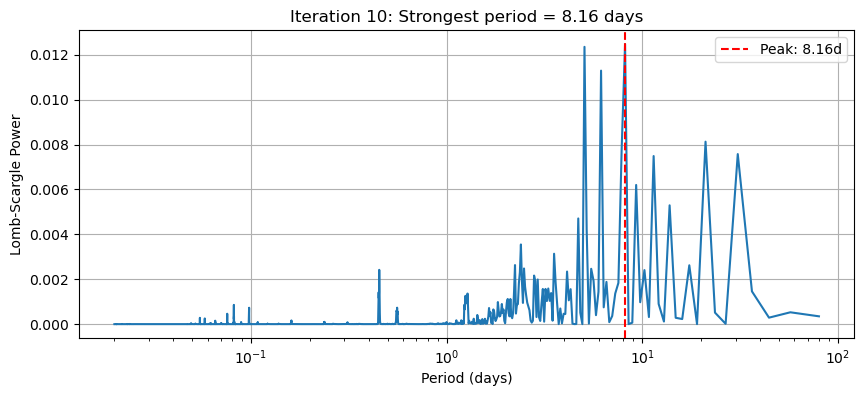

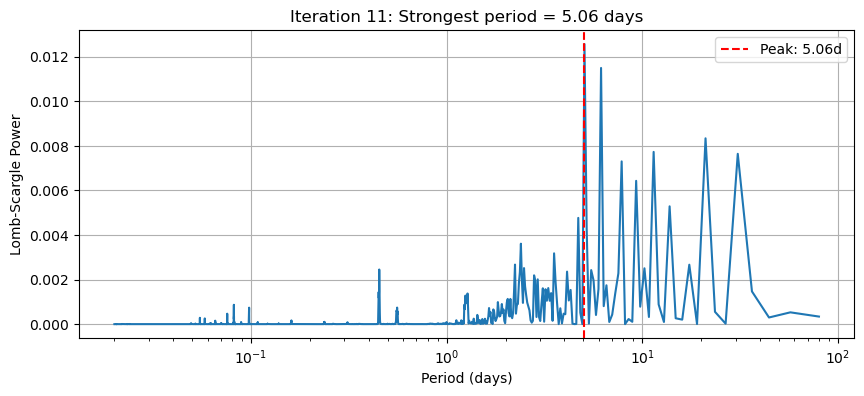

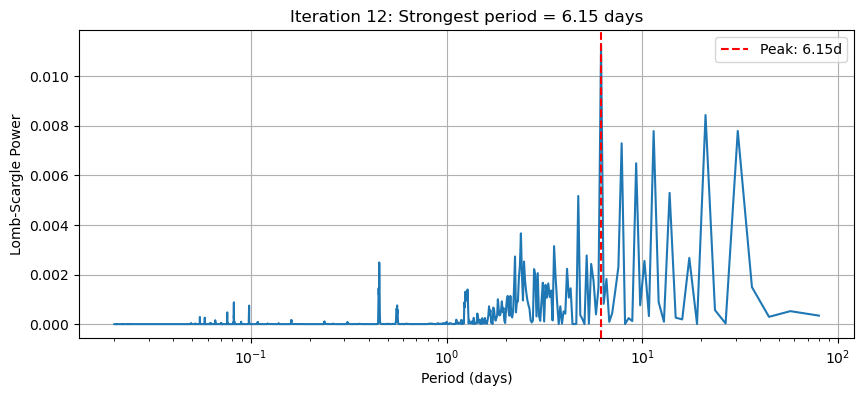

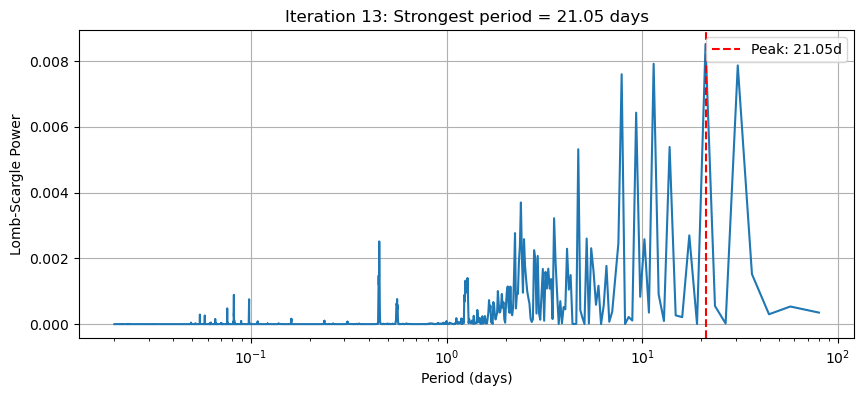

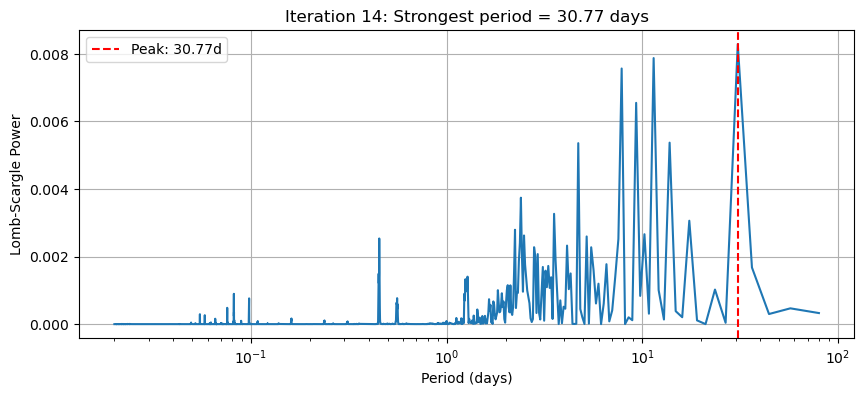

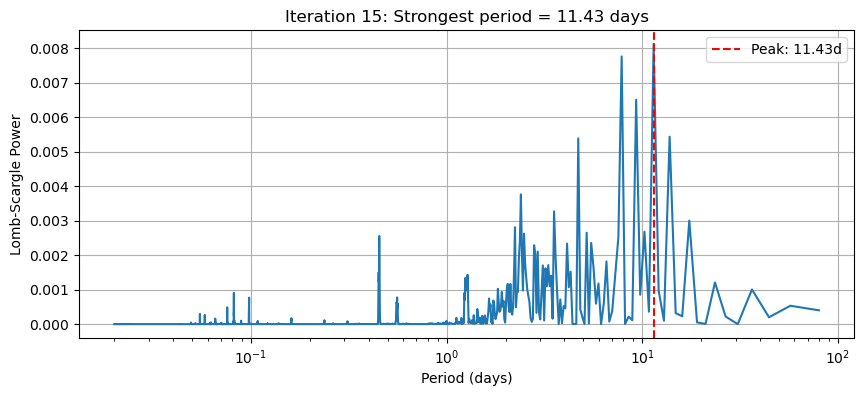

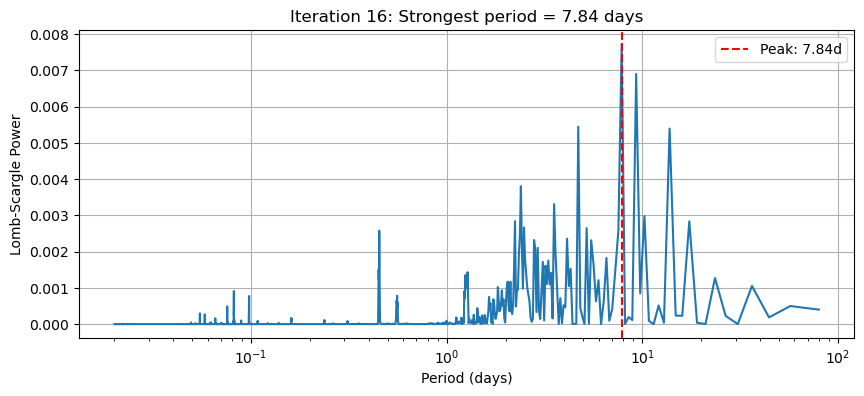

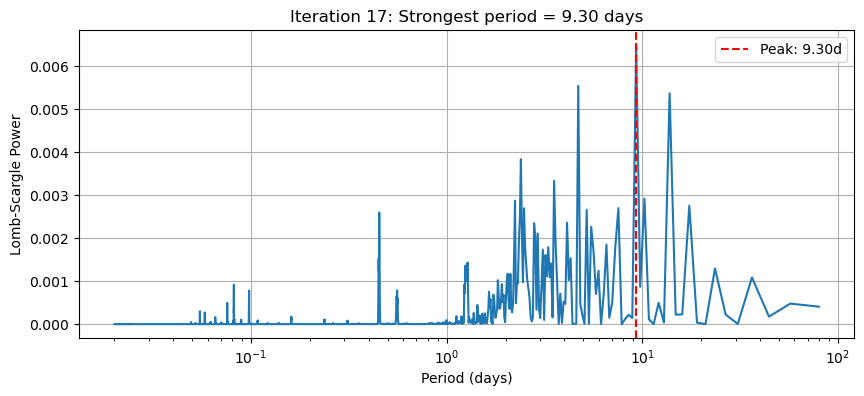

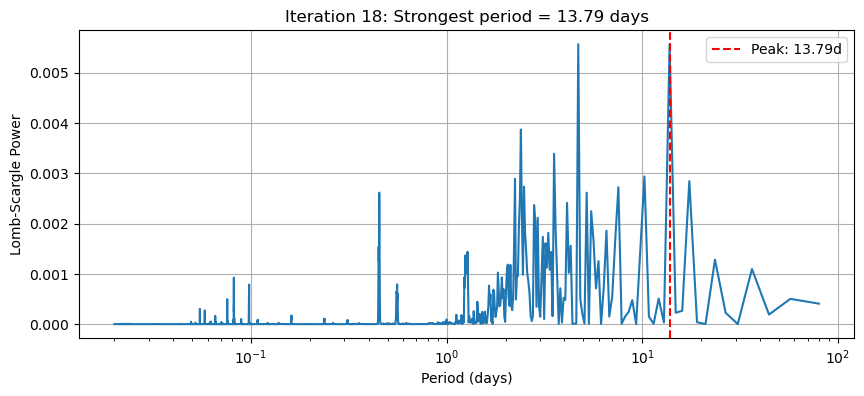

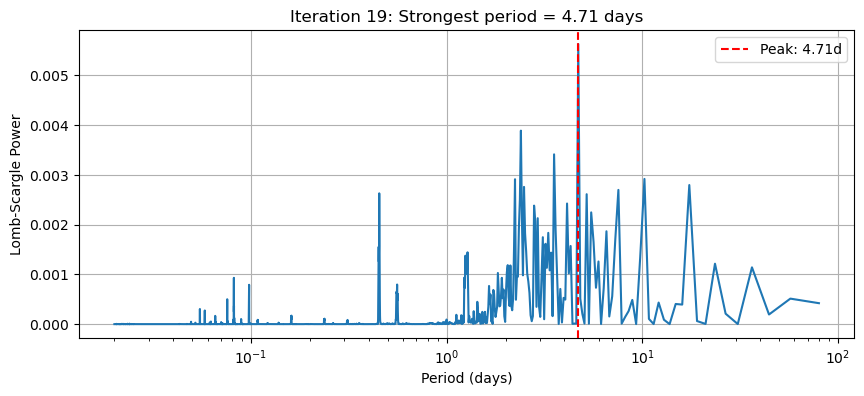

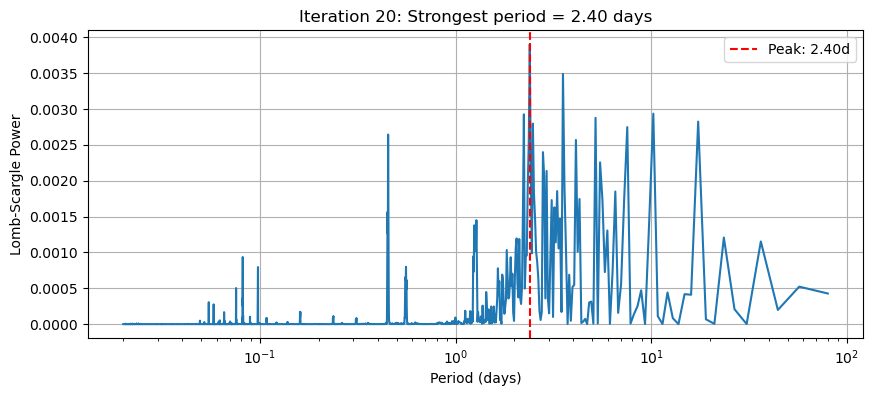

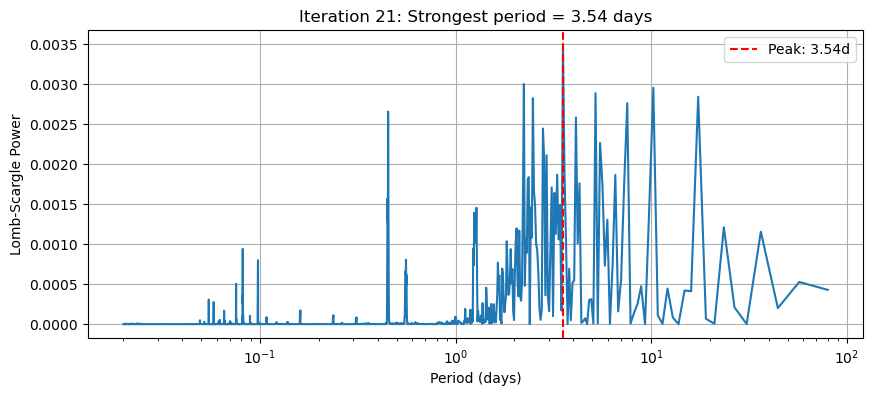

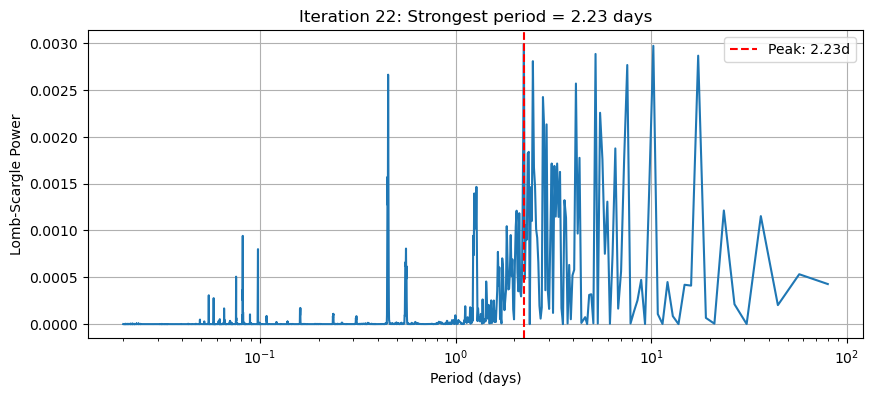

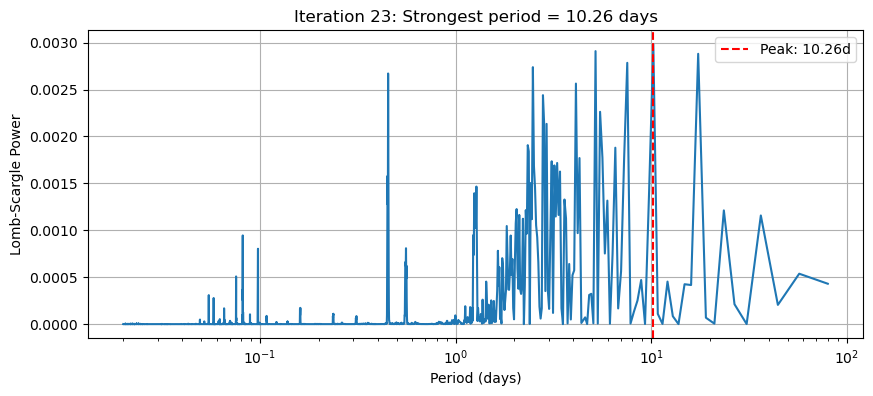

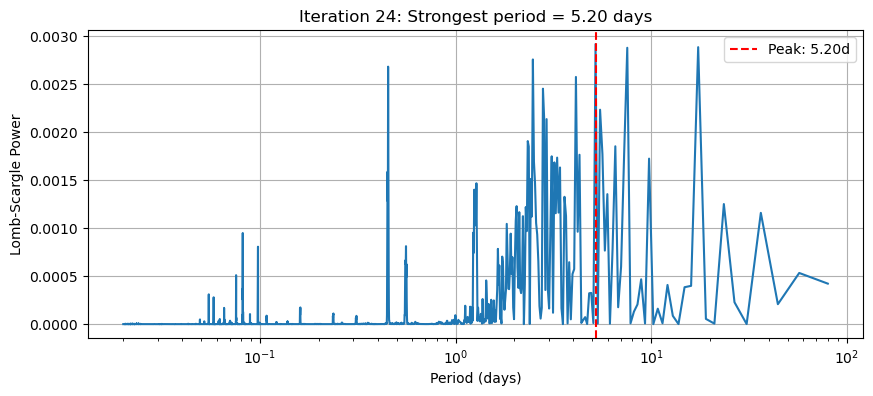

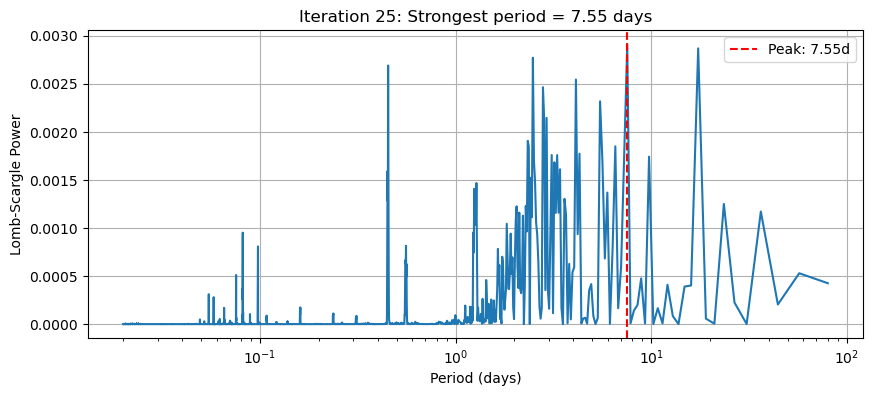

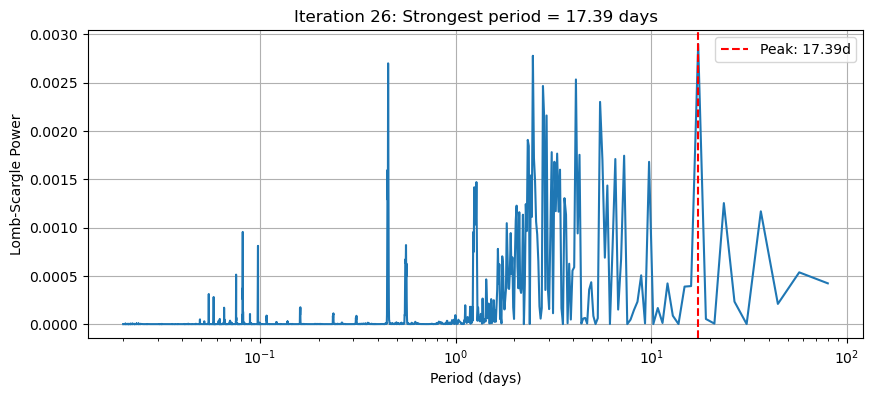

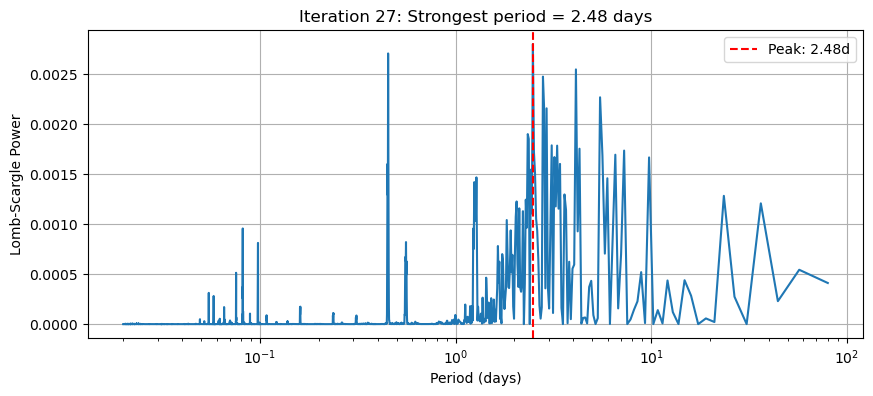

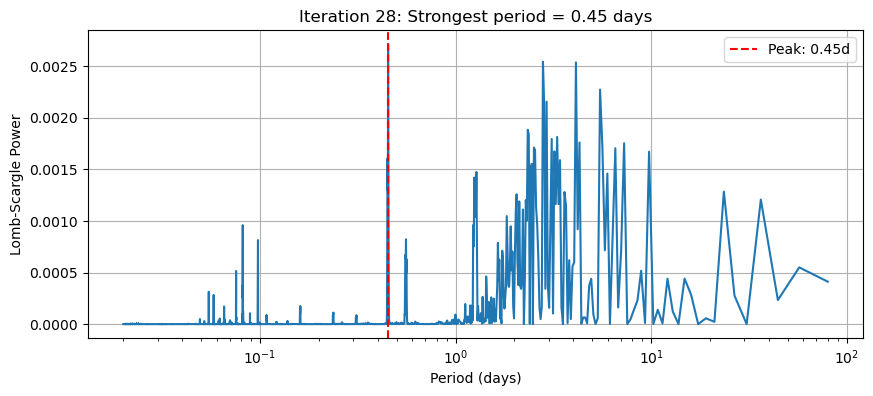

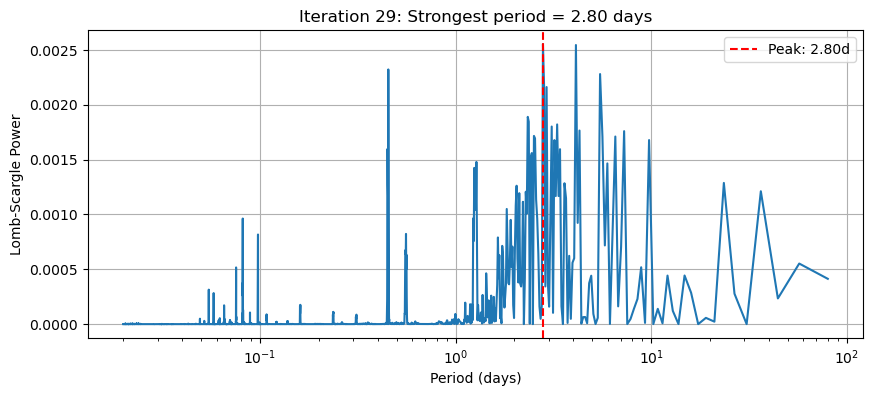

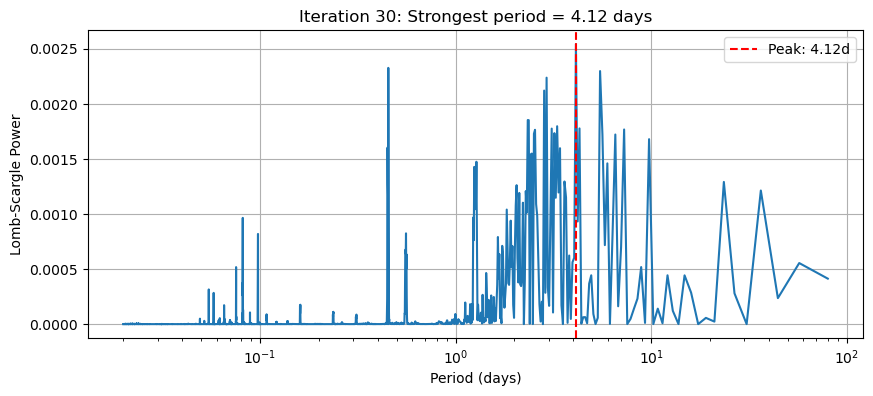

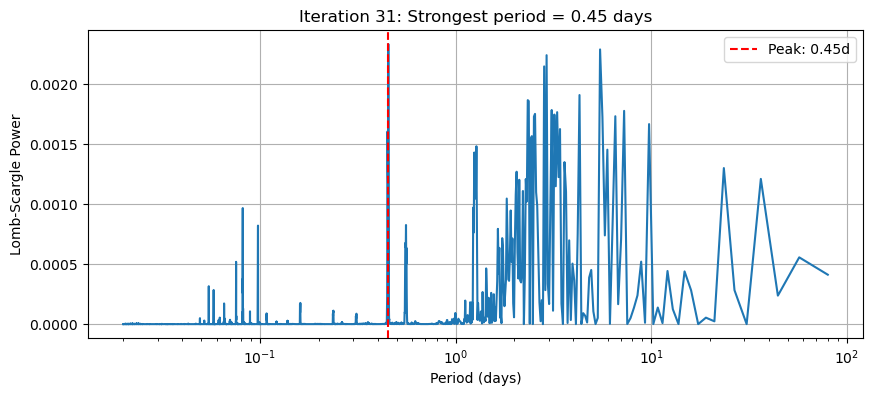

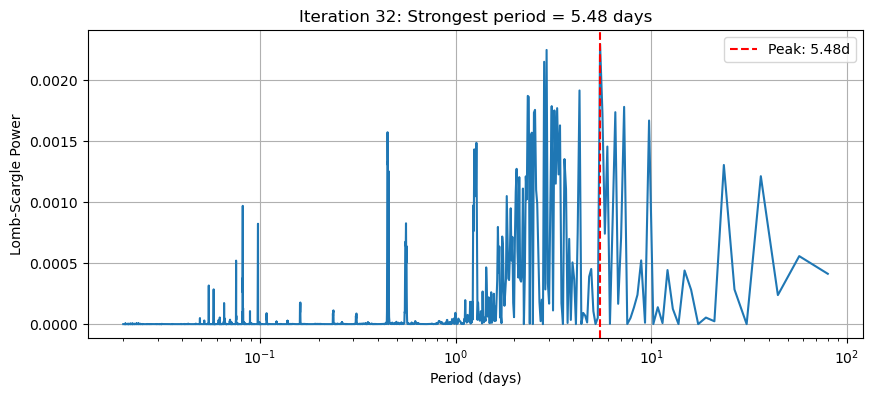

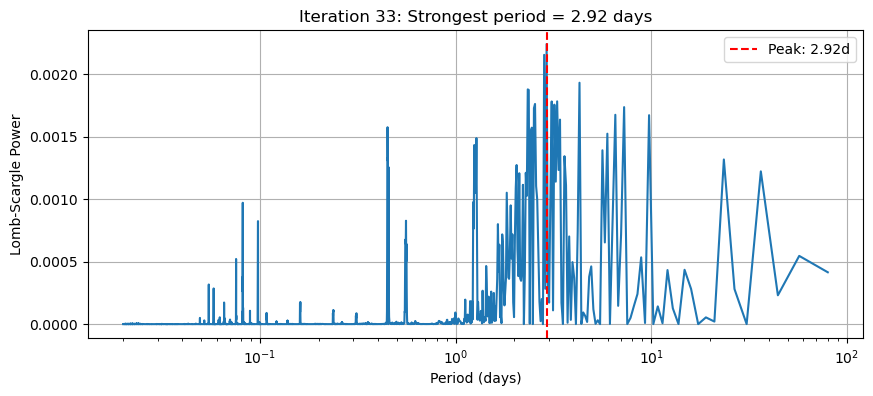

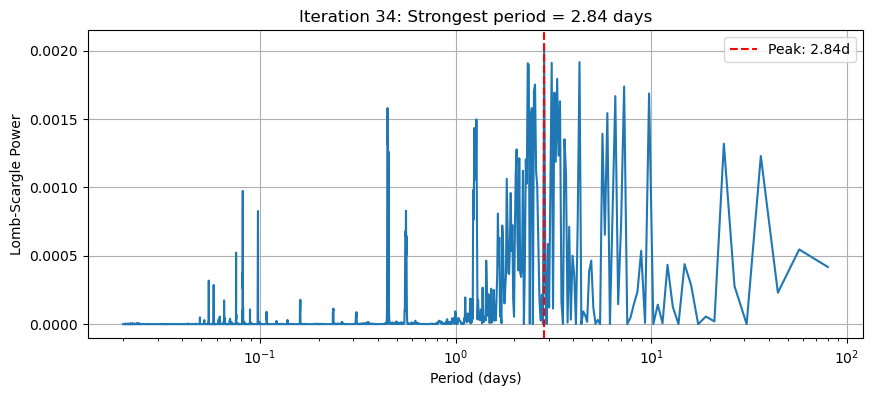

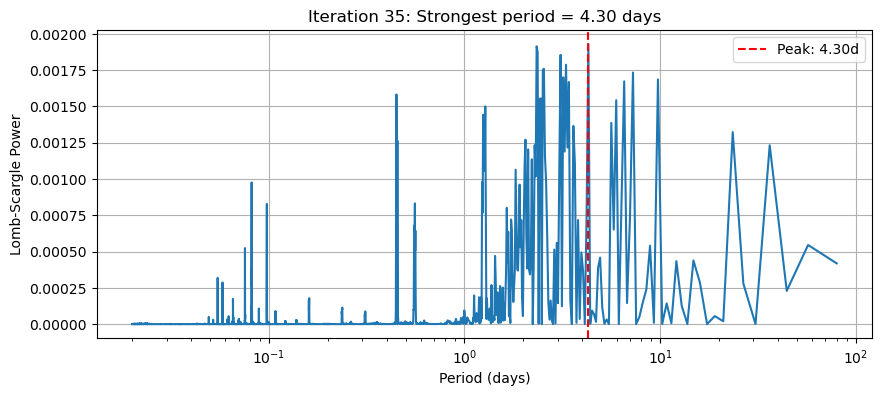

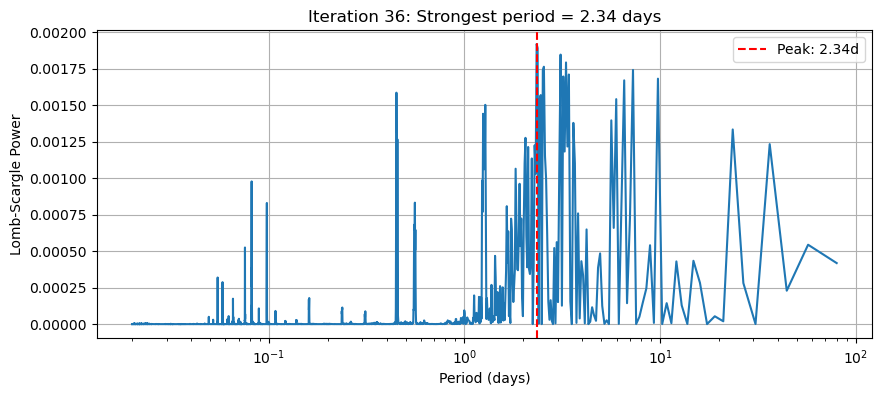

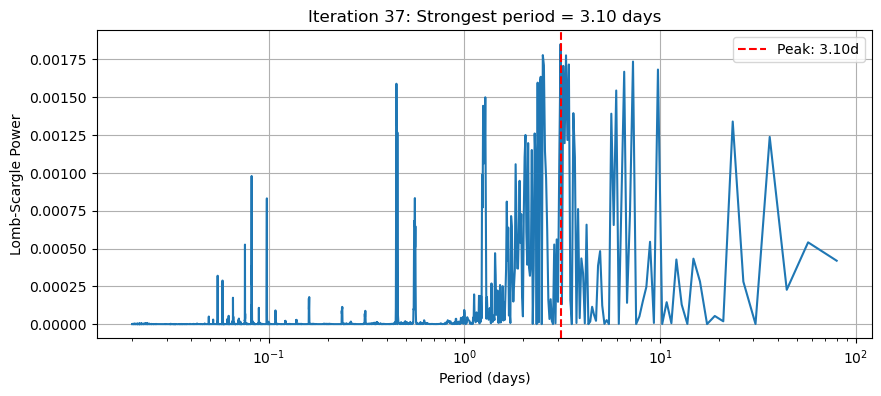

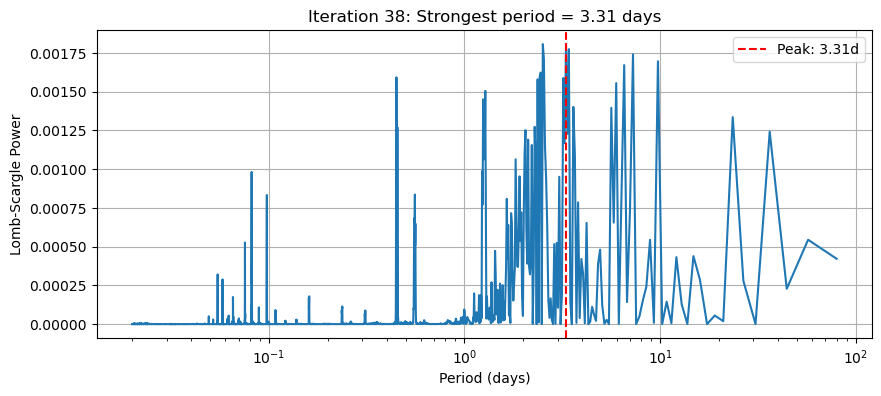

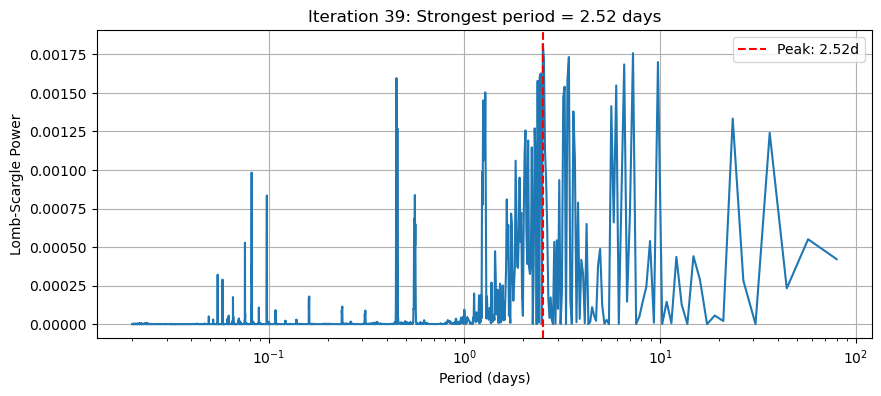

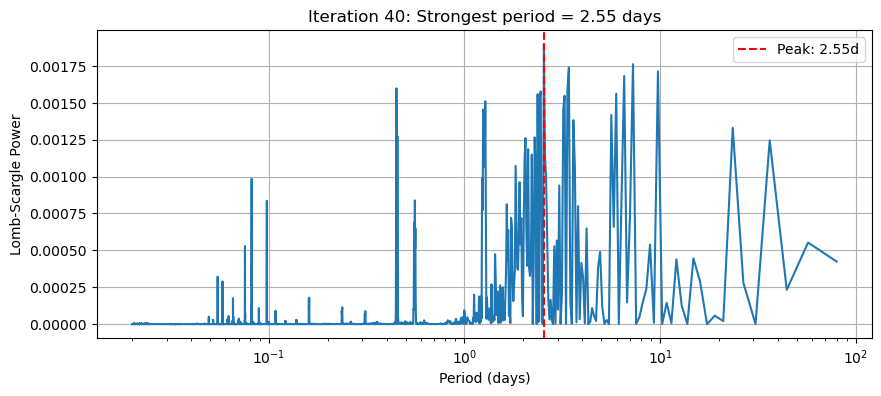

Strongest periods found in each iteration: [np.float64(23.53190362721737), np.float64(26.669333866773357), np.float64(4.495018459515501), np.float64(4.81995661605206), np.float64(19.04979638493963), np.float64(8.511779352614441), np.float64(4.396227659434149), np.float64(4.598351326182182), np.float64(4.9389667883008865), np.float64(8.16436510609633), np.float64(5.06400273483496), np.float64(6.154698428086697), np.float64(21.05495893872394), np.float64(30.77207155222158), np.float64(11.430041152263374), np.float64(7.844198634972935), np.float64(9.303558967201674), np.float64(13.794816079466088), np.float64(4.706546873069387), np.float64(2.395558190933103), np.float64(3.5403306114319855), np.float64(2.234962784148059), np.float64(10.257751788874357), np.float64(5.195533991933127), np.float64(7.548195329087049), np.float64(17.39334637964775), np.float64(2.4848332354832396), np.float64(0.45204483150886743), np.float64(2.79760780610639), np.float64(4.124298154707584), np.float64(0.45306871

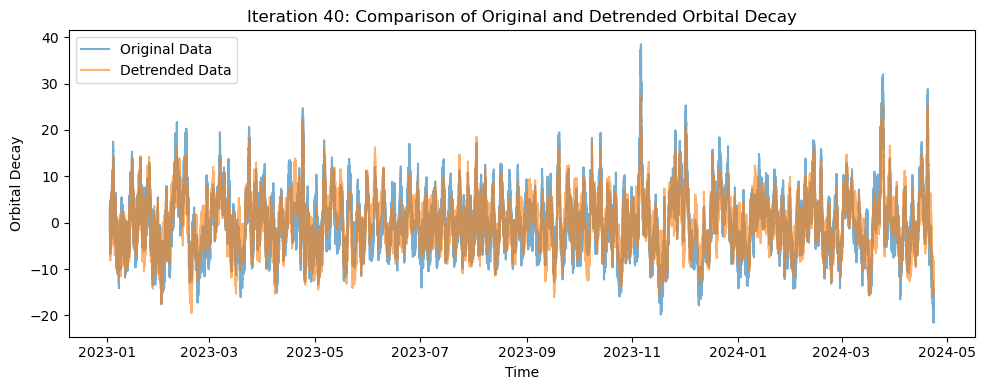

In [15]:
n_iterations = 40
residual = y.copy()
periods = []

for i in range(n_iterations):
    ls_iter = LombScargle(times_num, residual)
    power_iter = ls_iter.power(frequency)
    best_frequency = frequency[np.argmax(power_iter)]
    best_period = 1 / best_frequency
    periods.append(best_period)
    
    # Remove strongest period
    fit = ls_iter.model(times_num, best_frequency)
    residual = residual - fit
    
    plt.figure(figsize=(10, 4))
    plt.plot(1/frequency, power_iter)
    plt.xlabel('Period (days)')
    plt.ylabel('Lomb-Scargle Power')
    plt.title(f'Iteration {i+1}: Strongest period = {best_period:.2f} days')
    plt.xscale('log')
    plt.grid(True)
    plt.axvline(best_period, color='red', linestyle='--', label=f'Peak: {best_period:.2f}d')
    plt.legend()
    plt.show()

print("Strongest periods found in each iteration:", periods)

plt.figure(figsize=(10, 4))
plt.plot(times, y, label='Original Data', alpha=0.6)
plt.plot(times, residual, label='Detrended Data', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('Orbital Decay')
plt.title(f'Iteration {i+1}: Comparison of Original and Detrended Orbital Decay')
plt.legend()
plt.tight_layout()
plt.show()

#### Plot data in shorter time intervalls

In [16]:
GFOC_data['orbital_decay_residual'] = residual

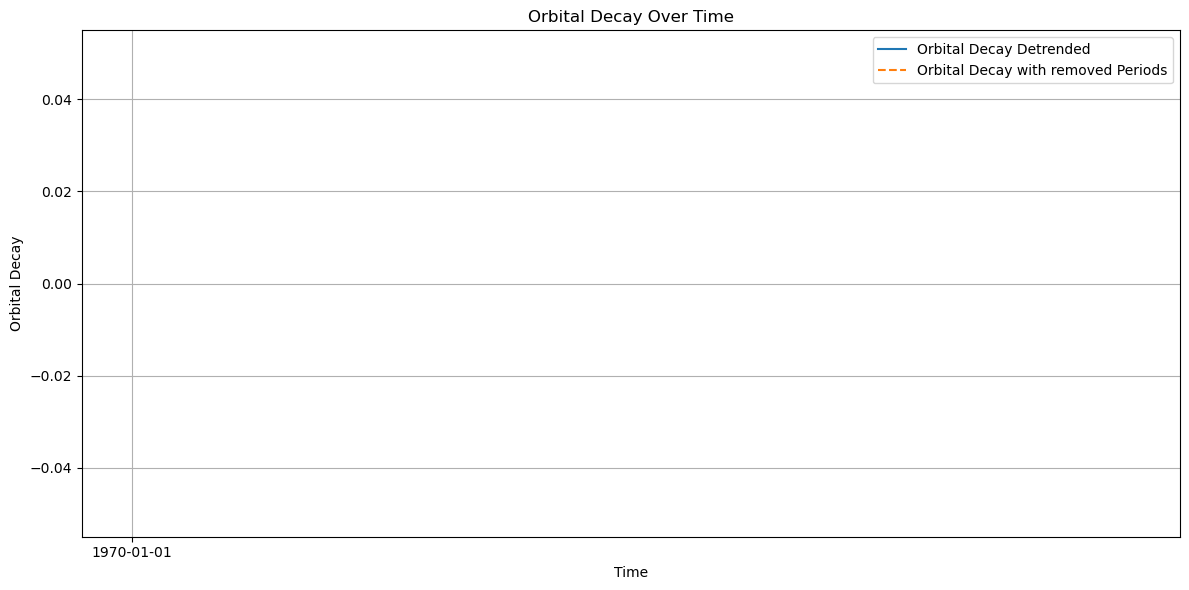

In [17]:
# =========================== Input ===================================
start_date = '2024-05-01 00:00:00'
end_date = '2024-05-15 00:00:00'
# start_date = GFOC_data['time'].values[0]
# end_date = GFOC_data['time'].values[-1]

# Add an option for monthly, daily, or hourly ticks
tick_interval = 'daily'  # Change to 'monthly', 'daily', or 'hourly'
tick_step = 2  # Step for the ticks (e.g., every month =1, every 2 months = 2, etc)

# plt.style.use('dark_background')
plt.style.use('default')

# =====================================================================


GFOC_subset = GFOC_data[(GFOC_data['time'] >= start_date) & (GFOC_data['time'] <= end_date)]
# Time conversion
GFOC_time = GFOC_subset['time']
GFOC_time = pd.to_datetime(GFOC_time, format='%Y-%m-%d %H:%M:%S')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(GFOC_time, GFOC_subset['orbital_decay_detrended'], label='Orbital Decay Detrended')
ax.plot(GFOC_time, GFOC_subset['orbital_decay_residual'], label='Orbital Decay with removed Periods', linestyle='--')
format_ticks(ax, tick_interval, tick_step)
ax.set_xlabel('Time')
ax.set_ylabel('Orbital Decay')
ax.set_title('Orbital Decay Over Time')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()